# Clustering and isolating flooded areas with contours to detect flood edge

This notebook outlines the steps and process of identifying flood areas from within an image. It demonstrates the steps and techniques used to isolate and generate a polygon for later use in GIS from a raw image.

Using information about colours in Notebook 2.1, clustering in 2.2 & 2.3 this Notebook performs clustering with feature reduction methods. OpenCV contours is used to define the cluster edge allowing us to approximate the floods edge. It is imagined that this edge can be later used to generate coordinates for use in GIS.

Workflow is as follows:
- 0.0 Prepare the environment
- 1.0 Load images
    - reduce image size
- 2.0 Perform clustering (gmm)
    - increase colour channels (RGBHS)
    - training the GMM model
    - execute clustering
    - test
- 3.0 Contour
    - Initial contouring
    - Contour reduction
- 4.0 Convert (yet to be implemented)



# 0.0 Prepare the environment

Preparation of the jupyter/python environment
- Import libraries
- Define functions

In [1]:
%load_ext autoreload
%autoreload 2

#!pip install -q -r requirements.txt

#~~ Standard Libraries
import os
import sys
import subprocess
import math

#--
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

#-- Computer Vision libraries
import cv2  # OpenCV library
import matplotlib.pylab as plt
import skimage
from skimage import io
from sklearn.mixture import GaussianMixture
import earthpy
import pickle

print("Done")

Done


In [2]:
def max_rgb_filter(image):
    """Reduce the less dominant RGB channels to zero (0).

    Keyword arguments:
    image -- numpy array that contains the image RGB data
    """
    # split the image into its BGR components
    (B, G, R, _) = cv2.split(image)
    # find the maximum pixel intensity values for each
    # (x, y)-coordinate,, then set all pixel values less
    # than M to zero
    M = np.maximum(np.maximum(R, G), B)
    R[R < M] = 0
    G[G < M] = 0
    B[B < M] = 0
    # merge the channels back together and return the image
    return cv2.merge([B, G, R, _])

def max_v_filter(image): # requires HSV image
    """Maximize the Value (V) channel in a HSV image.

    Keyword arguments:
    image -- numpy array that contains the image HSV data
    """
    (H, S, V) = cv2.split(image)
    #S[True] = 255 disable saturation overload to keep subtle color changes
    V[True] = 255
    return cv2.merge([H, S, V])
    
def pltImages(images):
    """Automatically plots images in a 4*n grid using using matplot.

    Keyword arguments:
    images -- List of numpy arrays containing the image data
    """
    # calculate columns
    if (len(images)) >= 4:
        columns = 4
    else:
        columns = len(images)
    rows = math.floor(len(images) / 4)
    # calulate row
    if (len(images) % 4) > 0:
        rows += 1
    total_plots = rows * columns
    # create plot
    _, ax = plt.subplots(rows, columns, sharey=True, figsize=(20,20)) 
    # blank image to use as filler
    blank = np.full(images[0].shape[:2], 0, dtype='uint8')
    #show single image
    if(len(images) == 1):
        ax.imshow(images[0], cmap='viridis')
        return 
    # show images
    if(rows == 1):
        for i in range(total_plots):
            if (i < len(images)):
                ax[i % columns].imshow(images[i], cmap='viridis')
            else:
                ax[i % columns].imshow(blank)      
    else:
        row = 0
        for i in range(total_plots):
            if (i < len(images)):
                ax[row][i % columns].imshow(images[i], cmap='viridis')
            else:
                 ax[row][i % columns].imshow(blank)
            row = math.floor((i + 1)  / columns)
    
    return
            

def eval_cluster(truth, cluster):
    """Evaluates two binary images against each other. Used to determine how accurately 1 image (cluster) matches the other image (truth).

    Keyword arguments:
    truth -- numpy array that containing the truth data.
    cluster -- numpy array that containing data for evaluation.
    """
     # 
    missed = np.less(cluster, truth)
    wrong = np.greater(cluster, truth)
    # total pixels in the image
    tot_pixels = truth.shape[0] * truth.shape[1]
    # calculate total pixels that are not flood related 
    nonflood_pixels = tot_pixels - truth.sum()
    # calculate total pixels that are flood related 
    flood_pixels = truth.sum()
    # output results expressed as percentage and display images
    print("Cluster over identified {p:.2f}% of non flood region".format(p = (wrong.sum() / nonflood_pixels) * 100))
    print("Cluster under identified {p:.2f} % of flood region".format(p = (missed.sum() / flood_pixels) * 100))
    pltImages([truth, cluster, missed, wrong])
    return

def super_image(image, blur):
    """Increases the features on the supplied image by producing the data set containg 5 channels of Red, Blue, Green, Hue, and Saturation.
        Images can also be blurred to decrease noise.
    Keyword arguments:
    image -- numpy array that containing the truth data.
    blur -- boolean (True = blurred, False = not blurred)
    """
    # Regular images
    HSV_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    max_RGB_img = max_rgb_filter(image)

    if blur:
        # blurred images
        k = 3 # blur amount
        HSV_img = cv2.medianBlur(HSV_img, k)
        max_RGB_img = cv2.medianBlur(max_RGB_img, k)

    # split omages into channels
    (R, G, B, _) = cv2.split(image)
    (H, S, V) = cv2.split(HSV_img)
 
    # return 5 channel super image
    return cv2.merge(([R ,G ,B ,H, S]))


def id_flood (gmm, super_img, cluster_idx):
    """Increases the features on the supplied image by producing the data set containg 5 channels of Red, Blue, Green, Hue, and Saturation.
        Images can also be blurred to decrease noise.
    Keyword arguments:
    gmm -- Guassian Mixed Model object
    super_img -- super_img for processing and extraction of clusters
    cluster_idx -- indexes of flood and flood + cloud clusters to be combined to form the final flood mask
    """
    # Convert to X*Y array
    vectorized = super_img.reshape((-1,channels))
    # Extract clusters
    gmm_cluster = gmm.predict(vectorized)
    gmm_images = gmm_cluster.reshape(super_img.shape[:2])
    #combine clusters (flood, flood + shadow)
    mask = np.logical_or(gmm_images == cluster_idx[0], gmm_images == cluster_idx[1])
    #return
    return mask


def reduce_contours(contours, hierachy, min_cont_area):
    """Decreases to number of contours by eliminating contours with a rea smaller than min_cont_area
    Keyword arguments:
    contours -- as generated by cv2.findContours
    hierachy -- as generated by cv2.findContours
    min_cont_area -- minimum contour area
    """
    new_contours = []
    for c in contours:
        if cv2.contourArea(c) > min_cont_area:
            new_contours.append(c)
    return new_contours


def open_gmm(file):
    """ Opens and returns the GMM from file
    Keyword arguments:
    file -- path/filename of GMM to open
    """
    with open(file, 'rb') as file:
        return pickle.load(file)


def save_gmm(gmm, file):
    """ Saves the GMM to file
    Keyword arguments:
    gmm - Intialised / trained GMM object
    file -- path/filename of where to save gmm
    """
    with open(file, 'wb') as file:
        pickle.dump(gmm, file)



# 1.0 Load the images
Images are retrieved from their persistent storage location in an s3 bucket. Because Jupyter notebook instances use ephemeral storage systems they are not suitable for long term storage.

Training / testing will be done with 3 images.
- Train:
    - Image to train the GMM clusters. Image will need to have a wide variety of features accounting for flood, cloud cover, land, trees, blur .etc
- Test:
    - Image containing flood data
    - Image containing NO flood data




In [3]:
#create local directory to store images
!mkdir ss/images

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/PIL/Image.py:2858: DecompressionBombWarning: Image size (100000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


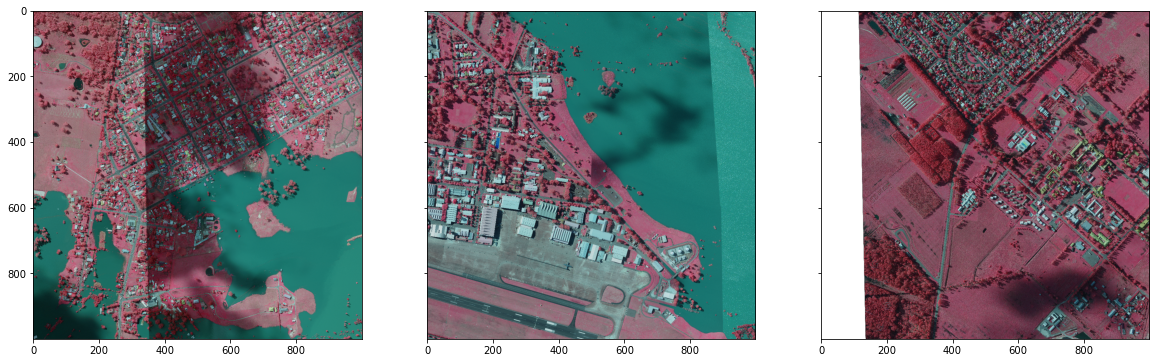

In [4]:
train_image = "Hawkesbury-Nepean_Floods_Central_Sector_2021_03_15cm_NRG_54.jp2"
fl_image = "Hawkesbury-Nepean_Floods_Central_Sector_2021_03_15cm_NRG_75.jp2"
nfl_image = "Hawkesbury-Nepean_Floods_Central_Sector_2021_03_15cm_NRG_80.jp2"


# variables for use in aws
import boto3
s3_client = boto3.client("s3")
bucket = "ss-csu-dataset"
site = "HawkesburyCentral"
path = "ss/images/"
#down load images from s3
key = f"tiles/{site}/CIR/{train_image}"
s3_client.download_file(bucket, key, f"{path}/{train_image}")
key = f"tiles/{site}/CIR/{fl_image}"
s3_client.download_file(bucket, key, f"{path}/{fl_image}")
key = f"tiles/{site}/CIR/{nfl_image}"
s3_client.download_file(bucket, key, f"{path}/{nfl_image}")


# reduce image size to improve productivity
img_sze = 0.1 
# read the images
train_img = io.imread(f"{path}{train_image}")
fl_img = io.imread(f"{path}{fl_image}")
nfl_img = io.imread(f"{path}{nfl_image}")
# resize the image
train_img = cv2.resize(train_img, (0,0), fx = img_sze, fy = img_sze)
fl_img = cv2.resize(fl_img, (0,0), fx = img_sze, fy = img_sze)
nfl_img = cv2.resize(nfl_img, (0,0), fx = img_sze, fy = img_sze)
# blank image
blank = np.full(train_img.shape[:2], 0, dtype='uint8')

pltImages([train_img, fl_img, nfl_img])

# 2.0 Extract Clusters



Define constants:
- ```blur``` - Option to blur images. Generally, not needed as the final contour indentification is reduced.
- ```n_components``` - Number of clusters to find in the training image
- ```min_cont_pts``` - Minimum number of points a contour must have to classed as valid / not noise / not false positive
- ```cluster_idx``` - List of clusters to combined to create the final flood mask. Currently designed for 2 ```[flood, flood + cloud]```

In [5]:
blur = False
n_components = 12
min_cont_pts = 100
cluster_idx = [0,8]

### 2.1 Guassian Mixture (GMM)

First, we will fit the ```train_img``` using GMM. Then we can use the GMM object to predict / define other images. Using GMM we will fit/train a GMM model. Using that same model, we can use it to predict / identify flood areas in other images. Using the same GMM model allows for repeatability and predictability in between runs, ablity to reuse the same model also means it is portable. If at some point, we want to train the GMM on another type of image we can load that into the pipeline without rewriting the base code. It also opens the possibility of training the GMM model on a purpose-built composite image to ensure all cluster scenarios are considered.

In [6]:
# create the super image
super_img = super_image(train_img, blur)
channels = super_img.shape[2] # number of channels in super image
print ("Super image shape "+ str(super_img.shape))
# flatten the super_img for use in GMM fitting
vectorized = super_img.reshape((-1,channels))
# Define and fit the model
#===== build new gmm
gmm = GaussianMixture(n_components=n_components, random_state=0) # set random state so results are repeatable
gmm.fit(vectorized)
save_gmm(gmm,"../models/2_4GMM.pkl")
#===== open existing gmm
#gmm = open_gmm("../models/2_4GMM.pkl")
print("GMM finished")

Super image shape (1000, 1000, 5)
GMM finished


### 2.2 Extract the clusters
Using the flood_id function the GMM model and the same image used for training we can isolate and combine the different flood segments (flood and flood + shadow) resulting in the segmentation of the complete area.


### 2.3 Test #1
Test against the same image used for training. This confirms everything is correctly set up.

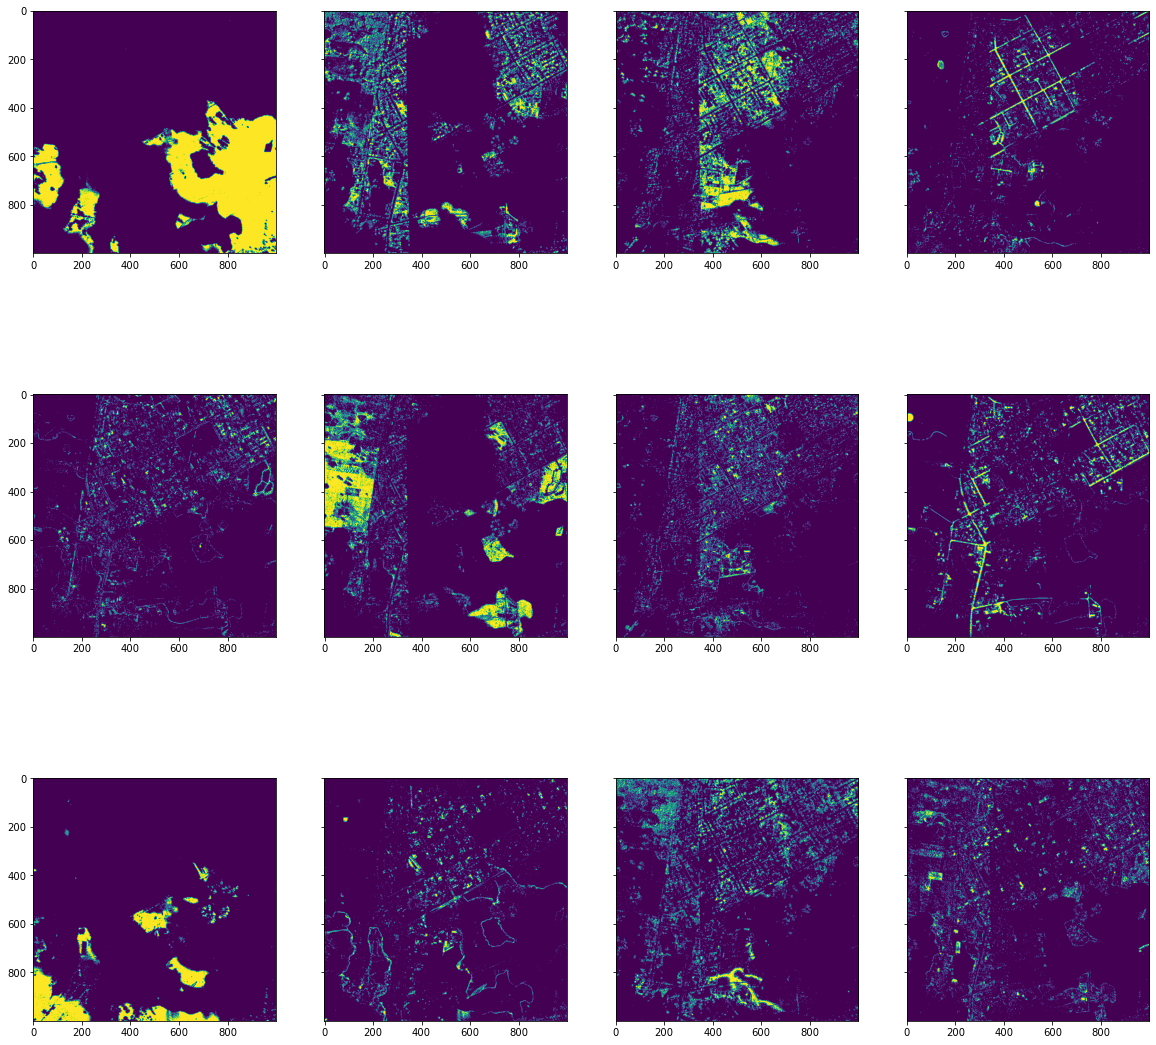

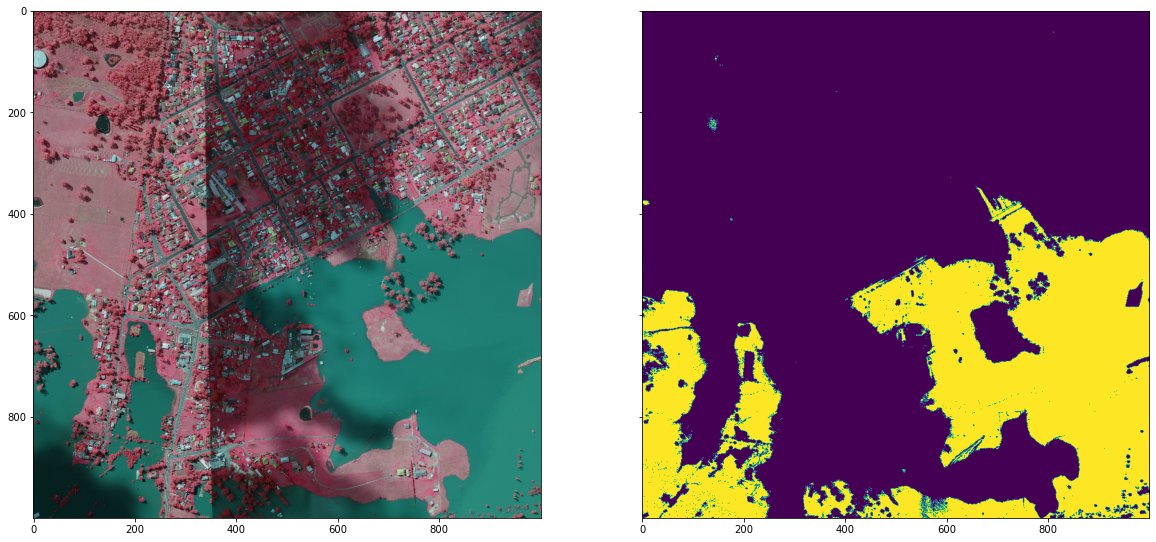

In [7]:
gmm_cluster = gmm.predict(vectorized)
gmm_cluster = gmm_cluster.reshape(train_img.shape[:2])

super_img = super_image(train_img, blur)
mask = id_flood(gmm, super_img, cluster_idx)
cluster = [] # clear images
for i in range(n_components):
    cluster.append(gmm_cluster == i)

pltImages(cluster)

pltImages([train_img, mask])

### 2.4 Test #2 

Test for false positives against an image with no flood

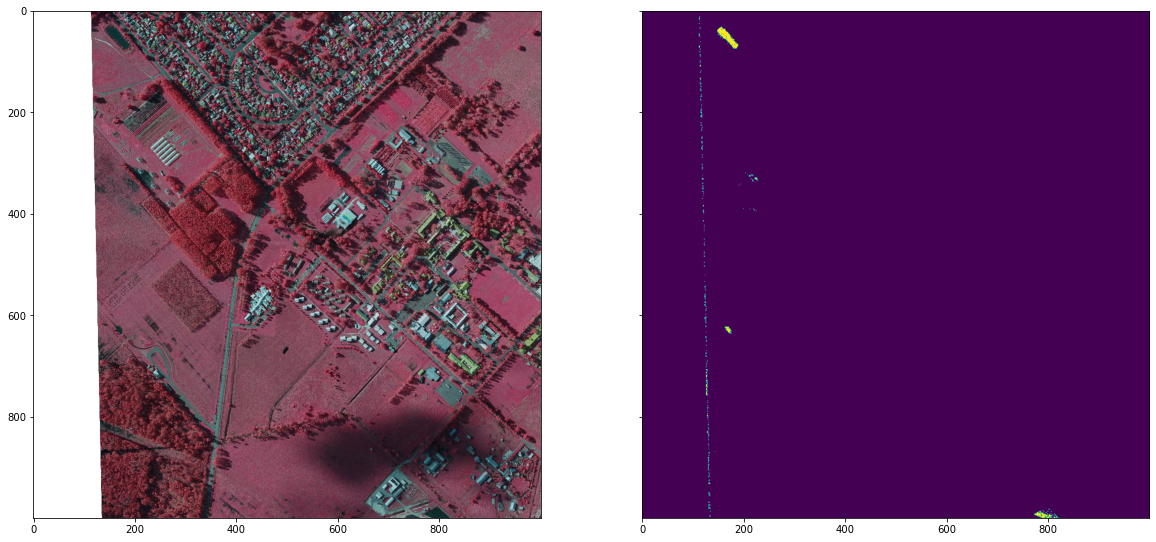

In [8]:
super_img = super_image(nfl_img, blur)
mask = id_flood(gmm, super_img, cluster_idx)
pltImages([nfl_img, mask])

### 2.5 Test #3

Test against an image with flood

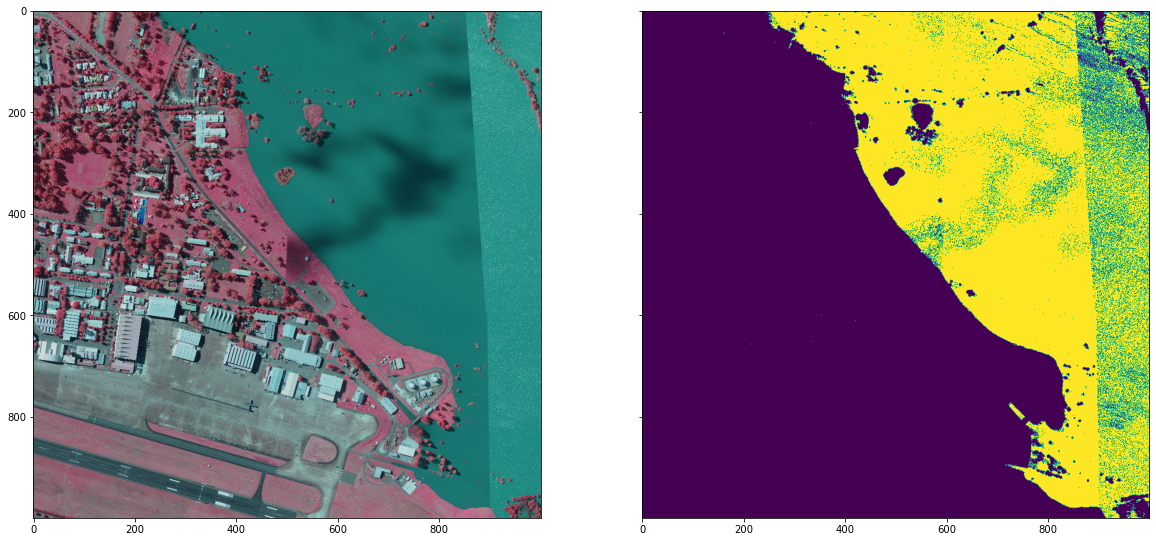

In [9]:
super_img = super_image(fl_img, blur)
mask = id_flood(gmm, super_img, cluster_idx)
pltImages([fl_img ,mask])

# 3.0 Contours

Defining and extracting the floods edge from the flood mask. Contours are reduced by eliminating the contours with points less than ```min_cont_pts```.

After the final set of contours has been identified the ```final_contours``` will contain a set of polygons containing the flood.

For conversion to SHP file or other processing the ```hierachy``` can be used to indetify which polygons are contained within. This can be used to indentify islands and such in the flood area. [https://docs.opencv.org/3.4/d5/daa/tutorial_js_contours_begin.html].

There could absolutly be improvements made to the ```contour_reduction``` method. Current reduction method is to eliminate contours with less than ```min_cont_pts``` points. This could be improved by reducing contours by shape, area, and location as the current process is not 100% accurate.


### 3.1 Contour all images

Total Contours: 2049
Total Final Contours: 32


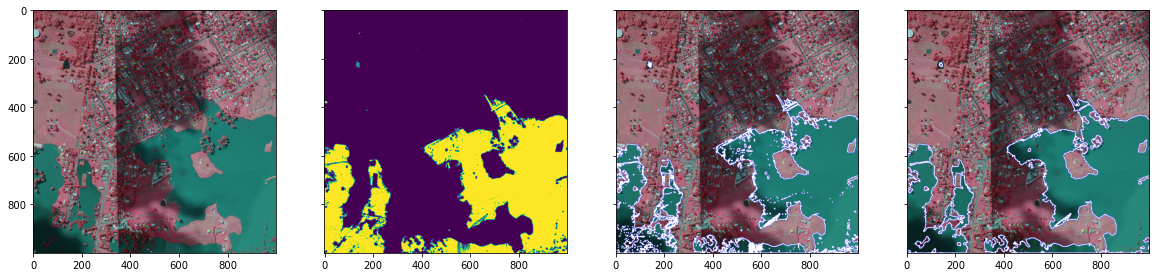

In [10]:
# Create the super image from the source
super_img = super_image(train_img, False)
# Extract the mask from the from the pretrained GMM clusters
mask = id_flood(gmm, super_img, cluster_idx)
# Get the inital set of contours
contours, hierarchy = cv2.findContours(np.uint8(mask), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
output = cv2.drawContours(train_img.copy(), contours, -1, (0,0,255), 2)
# reduce intial set of contours
final_contours = reduce_contours(contours, hierarchy, min_cont_pts)
final_output = cv2.drawContours(train_img.copy(), final_contours, -1, (0,0,255), 2)

# Display
print("Total Contours: " + str(len(contours)))
print("Total Final Contours: " + str(len(final_contours)))
pltImages([train_img, mask, output, final_output])

all_contours = final_contours

Total Contours: 220
Total Final Contours: 2


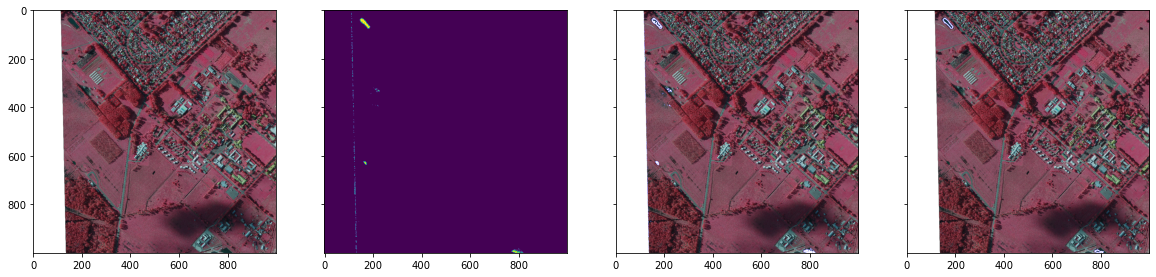

In [11]:
# Create the super image from the source
super_img = super_image(nfl_img, False)
# Extract the mask from the from the pretrained GMM clusters
mask = id_flood(gmm, super_img, cluster_idx)
# Get the inital set of contours
contours, hierarchy = cv2.findContours(np.uint8(mask), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
output = cv2.drawContours(nfl_img.copy(), contours, -1, (0,0,255), 2)
# reduce intial set of contours
final_contours = reduce_contours(contours, hierarchy, min_cont_pts)
final_output = cv2.drawContours(nfl_img.copy(), final_contours, -1, (0,0,255), 2)

# Display
print("Total Contours: " + str(len(contours)))
print("Total Final Contours: " + str(len(final_contours)))
pltImages([nfl_img, mask, output, final_output])

all_contours += final_contours

Total Contours: 18177
Total Final Contours: 24


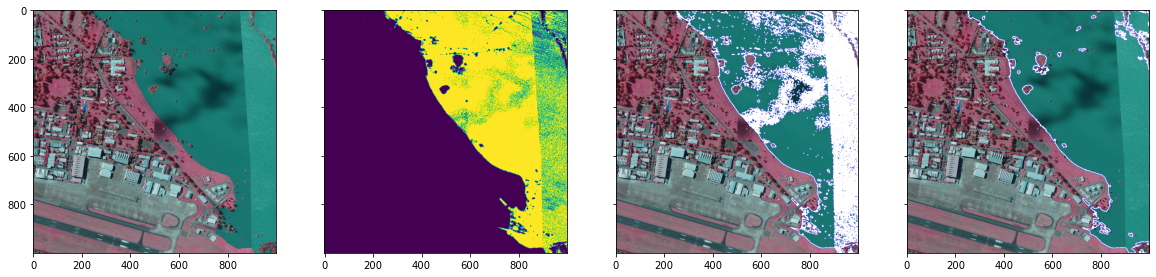

In [12]:
# Create the super image from the source
super_img = super_image(fl_img, False)
# Extract the mask from the from the pretrained GMM clusters
mask = id_flood(gmm, super_img, cluster_idx)
# Get the inital set of contours
contours, hierarchy = cv2.findContours(np.uint8(mask), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
output = cv2.drawContours(fl_img.copy(), contours, -1, (0,0,255), 2)
# reduce intial set of contours
final_contours = reduce_contours(contours, hierarchy, min_cont_pts)
final_output = cv2.drawContours(fl_img.copy(), final_contours, -1, (0,0,255), 2)

# Display
print("Total Contours: " + str(len(contours)))
print("Total Final Contours: " + str(len(final_contours)))
pltImages([fl_img, mask, output, final_output])

all_contours += final_contours

```final_contours``` now contains the set of polygons in X, Y format that we can use for conversion into a GIS / SHAPE file.

# 4.0 Convert

Once contours have been extracted the contours can be used to create a shape SHP file using the following steps.

1. Establish to datum of the image (where does pixel 0,0 relate to in real world coordinates.)
2. Convert contours points into real world coordinates by establishing pixel to groud distance relationshship.
3. Assemble data into shp compatible format. 
4. Output shape file


In [13]:
#Save flood extent coordinates to file
f = open("ss/images/contours_output.txt", "w")
f.write(str(final_contours))
f.close()